In [1]:
import tensorflow as tf
import model
import input
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import Image
import numpy as np
%matplotlib inline

In [69]:
def resize_image(img, size):
    pil_img = Image.fromarray(img)
    pil_img = pil_img.resize(size)
    img = np.array(pil_img.getdata(), dtype=img.dtype)
    return img.reshape(size+[3])

In [43]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

example = tf.placeholder(tf.float32, shape=[None, None, 3])
x = [input.transform_example(example, False)]
y = model.model(x, False)
y = tf.nn.softmax(y)

tf.global_variables_initializer().run()

saver = tf.train.Saver()
saver.restore(sess, "../saved_models/model.ckpt")

Tensor("norm1:0", shape=(1, 21, 21, 8), dtype=float32)
Tensor("norm2:0", shape=(1, 8, 8, 16), dtype=float32)
Tensor("Reshape:0", shape=(1, 1024), dtype=float32)


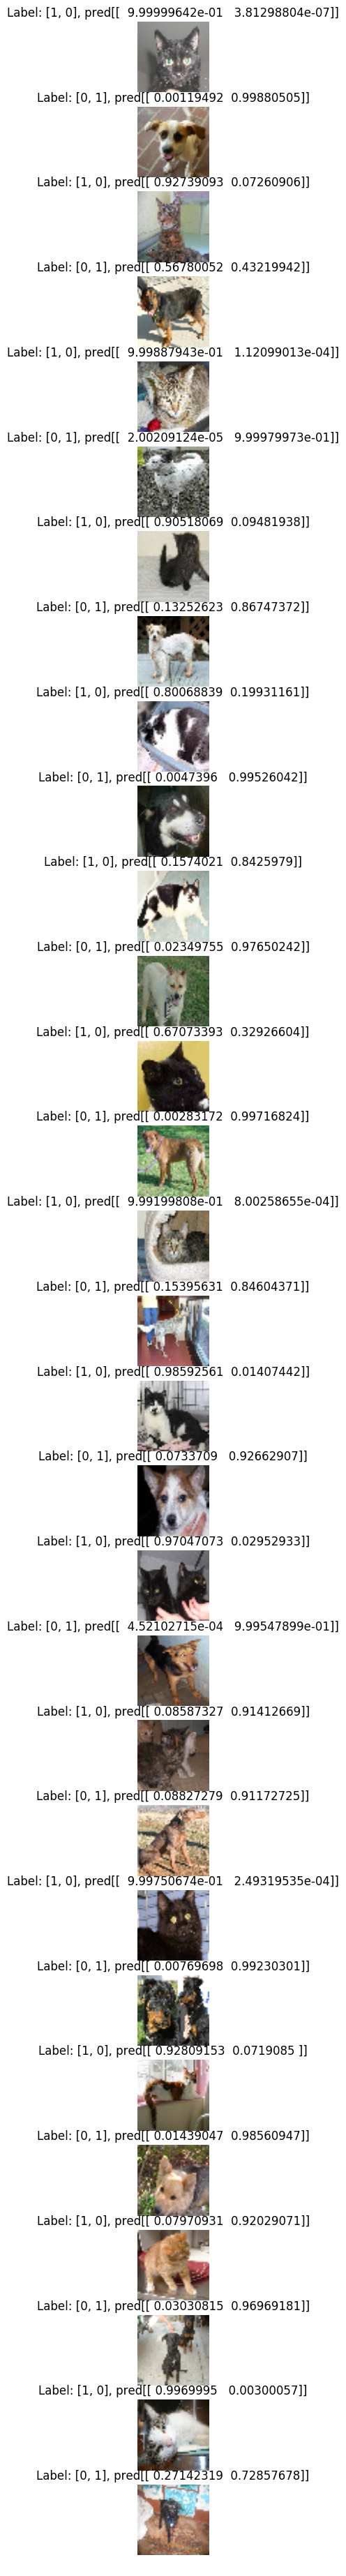

In [29]:
filenames, labels = input.get_filenames_labels(12500, .95, False, "../train")
plt.subplots(figsize=(50, 50))

for i in range(30):
    orig_img = mpimg.imread(filenames[i])
    imgs, pred = sess.run([example, y], feed_dict={example: orig_img})
    
    img = resize_image(orig_img, [50, 50])
    
    plt.subplot(32, 1, i+1)
    plt.title("Label: {}, pred{}".format(labels[i], pred))
    plt.axis('off')
    plt.imshow(img)
    
plt.show()

In [129]:
filenames, labels = input.get_filenames_labels(12500, .95, False, "../train")

tf.reset_default_graph()

sess = tf.InteractiveSession()

image_file = tf.read_file(filenames[0])
image = tf.image.decode_jpeg(image_file, channels=3)

image = [input.transform_example(image, False)]

#example = tf.placeholder(tf.float32, shape=[None, None, 3])
#x = tf.Variable(tf.truncated_normal(shape=[1, 50, 50, 3], stddev=.1))
x = tf.Variable(image)
#with tf.variable_scope("model"):
y = model.model(x, False)
loss = model.get_loss(y, [0, 1])
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1).minimize(loss)

tf.image_summary("images", x, max_images=1)
merged_summary_op = tf.summary.merge_all()

tf.global_variables_initializer().run()

print(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))

var_lst = tf.get_collection(tf.GraphKeys.MODEL_VARIABLES)
#print(tf.variables.all_variables())

saver = tf.train.Saver(var_lst[:])
saver.restore(sess, "../saved_models/model.ckpt")

# resized = tf.image.resize_images(tf.image.decode_jpeg(tf.read_file(filenames[0]), channels=3), [50, 50])
# resized = tf.image.per_image_standardization(resized)

#jpg_x = tf.image.encode_jpeg(image[0])

Tensor("norm1:0", shape=(1, 21, 21, 8), dtype=float32)
Tensor("norm2:0", shape=(1, 8, 8, 16), dtype=float32)
Tensor("Reshape:0", shape=(1, 1024), dtype=float32)


TypeError: Expected binary or unicode string, got <tensorflow.python.ops.variables.Variable object at 0x7f57ba741dd0>

In [127]:
logs_path = "../dreamLogs"
summary_writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())

print(y.eval())


#jpg_img = sess.run(optimizer, jpg_x)
sess.run(optimizer)
for i in range(1000):
    if i % 100 == 1:
        summary = sess.run(merged_summary_op)
        summary_writer.add_summary(summary, i)

print(y.eval())

#print(y.eval())
#print(x.eval())

[[ 10.37164497  -4.40803671]]
[[-2.83297563 -0.47168821]]


5.79658


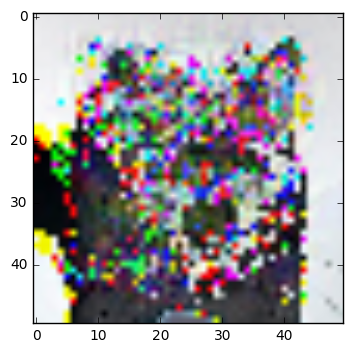

In [123]:
img = np.array(x.eval()[0])
print(img.max())
converted_img = (img * (255/img.max())).astype(int)
plt.imshow(converted_img)

#print(image[0].eval())

# img_file = open("../img.jpg", "wb")
# img_file.write(jpg_img)
# img_file.close()

#summary_writer.add_summary(summary, 1)

#img = x.eval()
#plt.imshow(img[0])

# img = np.array(image[0].eval())
# print(img.max())
# converted_img = (img * (255/img.max())).astype(int)
# plt.imshow(converted_img)
# print(converted_img)

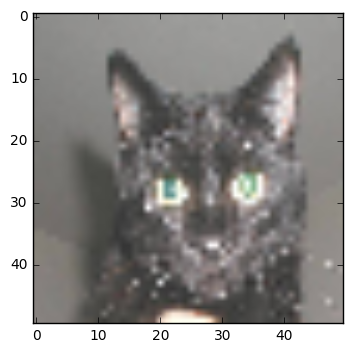

In [70]:
disp_img = mpimg.imread(filenames[0])
plt.imshow(resize_image(disp_img, [50, 50]))

In [23]:
example = tf.placeholder(tf.float32, shape=[None, None, None, 3])
x = tf.image.resize_images(example, [50, 50])

print("x", x)
shape = x.get_shape().as_list()
print("x size", shape[1] * shape[2] * shape[3])

conv1 = tf.contrib.layers.convolution2d(x, 8, [6, 6], [1,1], "VALID",
                                        weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                        biases_initializer=tf.constant_initializer(0.0),
                                        activation_fn=tf.nn.relu)
conv1 = tf.nn.max_pool(conv1, [1, 4, 4, 1], [1, 2, 2, 1], 'VALID')
conv1 = tf.nn.lrn(conv1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')

shape = conv1.get_shape().as_list()
print("conv1 size", shape[1] * shape[2] * shape[3])
print(conv1)

last_conv = tf.contrib.layers.convolution2d(conv1, 16, [5,5], [1,1], "VALID",
                                            weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                            biases_initializer=tf.constant_initializer(0.0),
                                            activation_fn=tf.nn.relu)
last_conv = tf.nn.max_pool(last_conv, [1, 3, 3, 1], [1, 2, 2, 1], 'VALID')
last_conv = tf.nn.lrn(last_conv, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')

print(last_conv)

shape = last_conv.get_shape().as_list()
reshaped_last_conv = tf.reshape(last_conv, [-1, shape[1] * shape[2] * shape[3]])

print(reshaped_last_conv)

fully_connect = tf.contrib.layers.fully_connected(reshaped_last_conv, 100,
                                                 weights_initializer=tf.contrib.layers.xavier_initializer())

y = tf.contrib.layers.fully_connected(fully_connect, 2,
                                      biases_initializer=tf.constant_initializer(0.0),
                                      weights_initializer=tf.contrib.layers.xavier_initializer(),
                                      activation_fn=None)

('x', <tf.Tensor 'ResizeBilinear:0' shape=(?, 50, 50, 3) dtype=float32>)
('x size', 7500)
('conv1 size', 3528)
Tensor("norm1_1:0", shape=(?, 21, 21, 8), dtype=float32)
Tensor("norm2_1:0", shape=(?, 8, 8, 16), dtype=float32)
Tensor("Reshape_4:0", shape=(?, 1024), dtype=float32)
